### Engineering year one ###

Accomodate more engineering downtime in year one: 
* slewtime -- add jerk, maybe start slew speeds at 40%
* downtime -- 50% chance of 15 minute -- 6 hours of engineering downtime at the start, ramping down over time .. at year one, likely not quite at nominal but close
* worse seeing? (this might be sorted by comcam and lsstcam commissioning though?)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord
import astropy.units as u
from rubin_scheduler.scheduler.model_observatory import ModelObservatory, KinemModel, tma_movement, rotator_movement
import rubin_scheduler.site_models as site_models
from rubin_scheduler.utils import Site, alt_az_pa_from_ra_dec, approx_ra_dec2_alt_az, calc_lmst, angular_separation
from rubin_scheduler.scheduler.utils import generate_all_sky

### Slewtime

In [2]:
lsst_site = Site('LSST')
lsst_loc = lsst_site.to_earth_location()

# survey start, for year 1 engineering time
start_time = Time("2025-08-01T10:00:00", format='isot', scale='utc')

In [3]:
sky = generate_all_sky(nside=64)
sky['ra_rad'] = np.radians(sky['ra'])
sky['dec_rad'] = np.radians(sky['dec'])
mjd_now = start_time.mjd
sky['alt'], sky['az'], sky['pa'] = alt_az_pa_from_ra_dec(ra=sky['ra'], dec=sky['dec'], mjd=mjd_now, site_longitude=lsst_site.longitude, site_latitude=lsst_site.latitude)

In [16]:
kinem_model = KinemModel(mjd0 = mjd_now)
kinem_model.setup_dome()
tma = tma_movement(40)
print(tma)
# 70% speeds (including jerk) for tma movement -- equivalent to previous default
kinem_model.setup_telescope(**tma)
kinem_model.setup_camera(readtime=2.4, **rotator_movement(100))

# All defaults for previous model comparison point.
tma = tma_movement(70)
prev_kinem_model = KinemModel(mjd0 = mjd_now)
prev_kinem_model.setup_telescope(**tma)
prev_kinem_model.setup_camera(readtime=2.4, **rotator_movement(100))

{'azimuth_maxspeed': 4.0, 'azimuth_accel': 4.0, 'azimuth_jerk': 16.0, 'altitude_maxspeed': 2.0, 'altitude_accel': 2.0, 'altitude_jerk': 8.0, 'settle_time': 3.0}


Text(0, 0.5, 'Slew time difference (seconds)')

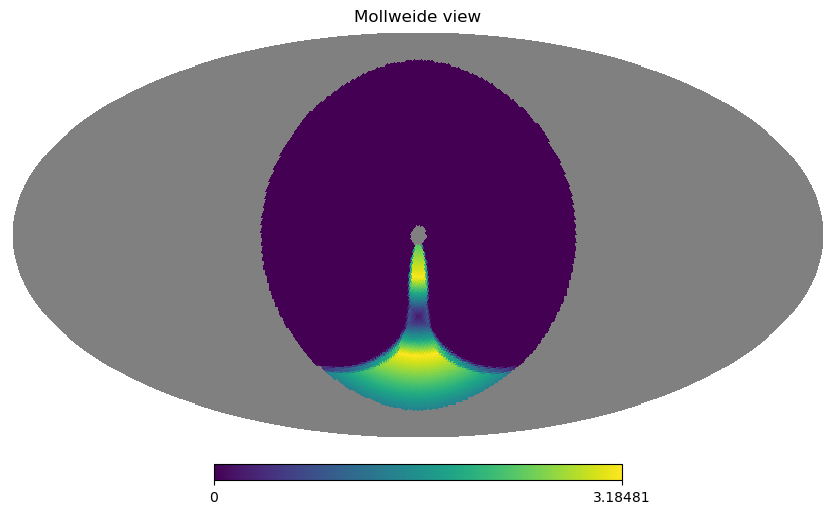

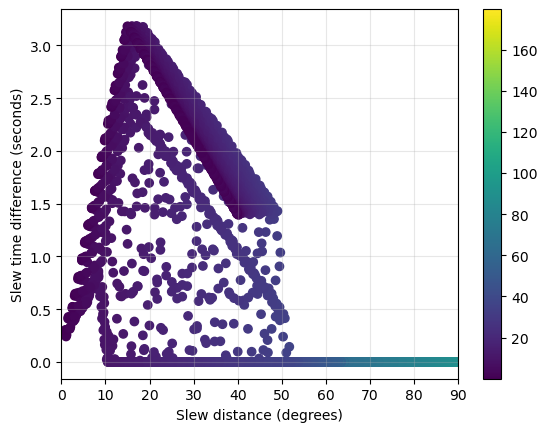

In [17]:
# Estimate differences in slew times for different speed capabilities
starting_alt = 60
starting_az = 180

previous = prev_kinem_model.slew_times(ra_rad=np.ones(len(sky['ra'])), dec_rad=np.ones(len(sky['ra'])), mjd=mjd_now,
                                               rot_sky_pos=None, rot_tel_pos=np.zeros(len(sky['ra'])),
                                               filtername=None,
                                               alt_rad=np.radians(sky['alt']), az_rad=np.radians(sky['az']),
                                               lax_dome=True, 
                                               starting_alt_rad=np.radians(starting_alt), starting_az_rad=np.radians(starting_az),
                                               starting_rot_tel_pos_rad=0, update_tracking=False)


new = kinem_model.slew_times(ra_rad=np.ones(len(sky['ra'])), dec_rad=np.ones(len(sky['ra'])), mjd=mjd_now,
                                               rot_sky_pos=None, rot_tel_pos=np.zeros(len(sky['ra'])),
                                               filtername=None,
                                               alt_rad=np.radians(sky['alt']), az_rad=np.radians(sky['az']),
                                               lax_dome=True, 
                                               starting_alt_rad=np.radians(starting_alt), starting_az_rad=np.radians(starting_az),
                                               starting_rot_tel_pos_rad=0, update_tracking=False)

lmst = calc_lmst(mjd=mjd_now, longitude_rad=lsst_site.longitude_rad)/24*360

#hp.mollview(previous, rot=(lmst, lsst_site.latitude, 0))
#hp.mollview(new, rot=(lmst, lsst_site.latitude, 0))
hp.mollview(new - previous, rot=(lmst, lsst_site.latitude, 0))

plt.figure()
dist = angular_separation(starting_alt, starting_az, sky['alt'], sky['az'])
plt.scatter(dist, new-previous, c=np.abs(sky['az']-starting_az))
plt.colorbar()
plt.xlim(0, 90)
plt.grid(True, alpha=0.3)
plt.xlabel("Slew distance (degrees)")
plt.ylabel("Slew time difference (seconds)")

### Downtime

In [54]:
# default downtime - mix of scheduled and unscheduled downtime.

sched_downtime = site_models.ScheduledDowntimeData(start_time)
unsched_downtime = site_models.UnscheduledDowntimeData(start_time)

almanac = site_models.Almanac(mjd_start=start_time.mjd)

In [55]:
# year one night time 
year1_sunsets = np.where((almanac.sunsets['night'] >= 0) & (almanac.sunsets['night'] < 366))
sunset = almanac.sunsets[year1_sunsets]['sun_n12_setting']
sunrise = almanac.sunsets[year1_sunsets]['sun_n12_rising']

year10_sunsets = np.where((almanac.sunsets['night'] >= 0) & (almanac.sunsets['night'] < 3651))
sunset10 = almanac.sunsets[year10_sunsets]['sun_n12_setting']
sunrise10 = almanac.sunsets[year10_sunsets]['sun_n12_rising']

stepsize = 1/60/24.0  # stepsize in days
year1 = np.arange(sunset[0], sunrise[-1] + stepsize/2., stepsize)
nights = np.zeros(len(year1)) - 1
night_mask = np.zeros(len(year1))

                        
for i, (s, r) in enumerate(zip(sunset, sunrise)):
    nn = np.where((year1 >= s) & (year1 <=r), 1, 0)
    night_mask += nn
    nights[np.where(nn>0)] = i


In [56]:
scheduled_downtime = sched_downtime()
sched_down_mask = np.zeros(len(year1))
for start, end in zip(scheduled_downtime['start'], scheduled_downtime['end']):
    nn = np.where((year1 >= start.mjd) & (year1 <= end.mjd), 1, 0)
    sched_down_mask += nn
# Flip so that "1" is good and uptime
sched_down_mask = np.where(sched_down_mask == 1, 0, 1)

unscheduled_downtime = unsched_downtime()
unsched_down_mask = np.zeros(len(year1))
for start, end in zip(unscheduled_downtime['start'], unscheduled_downtime['end']):
    nn = np.where((year1 >= start.mjd) & (year1 <= end.mjd), 1, 0)
    unsched_down_mask += nn
unsched_down_mask = np.where(unsched_down_mask == 1, 0, 1)

# Coincidence how close these are in the first year
print(len(np.where(unsched_down_mask == 0)[0]) * stepsize, len(np.where(sched_down_mask == 0)[0]) * stepsize)

14.78125 14.0


Text(0.5, 0, 'Days into survey')

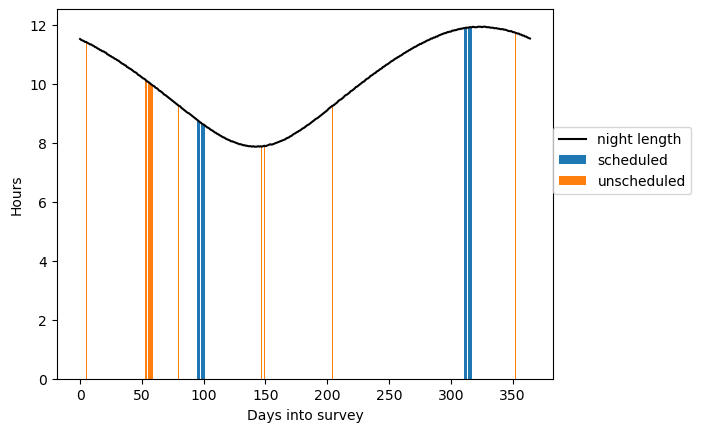

In [57]:
night_len = []
sched_down_len = []
unsched_down_len = []
nnights = np.arange(0, nights.max())
for n in nnights:
    val = year1[np.where(nights == n)]
    night_len.append(len(val) * stepsize * 24)
    val = year1[np.where((nights == n) & (sched_down_mask == 0))]
    sched_down_len.append(len(val) * stepsize * 24)
    val = year1[np.where((nights == n) & (unsched_down_mask == 0))]
    unsched_down_len.append(len(val) * stepsize * 24)    
night_len = np.array(night_len)
plt.plot(nnights, night_len, color='k', label='night length')
plt.bar(nnights, sched_down_len, label='scheduled')
plt.bar(nnights, unsched_down_len, label='unscheduled')
plt.legend(loc=(1.0, 0.5))
plt.ylabel("Hours")
plt.xlabel("Days into survey")

The problem with the above is that the downtime is far too little. 
Within the first year, a 'reasonable estimate' is a 50% chance of between 15 minutes to 6 hours of downtime on any given night. How this reduces over time is uncertain.
The current scheduled downtimes in the first year are just 7 day periods of maintenance .. hard to know how this might change, but a week of planned downtime to fix things may not be unreasonable, so I'll leave those alone.

In [58]:
for s in scheduled_downtime:
    if s['end'] < start_time + TimeDelta(3652, format='jd'): 
        print(s['activity'],  s['start'].iso, s['end'] - s['start'], s['start']-start_time)

general maintenance 2025-06-07 15:50:24.000 7.0 -54.75709490740741
general maintenance 2025-11-03 15:50:24.000 7.0 94.2429050925926
general maintenance 2026-06-07 15:50:24.000 7.0 310.2429050925926
general maintenance 2026-11-03 15:50:24.000 7.0 459.2429050925926
recoat mirror 2027-06-07 15:50:24.000 14.0 675.2429050925925
general maintenance 2028-06-06 15:50:24.000 7.0 1040.2429050925925
general maintenance 2028-11-02 15:50:24.000 7.0 1189.2429050925925
recoat mirror 2029-06-06 15:50:24.000 14.0 1405.2429050925925
general maintenance 2030-06-06 15:50:24.000 7.0 1770.2429050925925
general maintenance 2030-11-02 15:50:24.000 7.0 1919.2429050925925
recoat mirror 2031-06-06 15:50:24.000 14.0 2135.2429050925925
general maintenance 2032-06-05 15:50:24.000 7.0 2500.2429050925925
general maintenance 2032-11-01 15:50:24.000 7.0 2649.2429050925925
recoat mirror 2033-06-05 15:50:24.000 14.0 2865.2429050925925
general maintenance 2034-06-05 15:50:24.000 7.0 3230.2429050925925
general maintenance 

In [87]:
# Make a new unscheduled downtime class that adds significantly more unscheduled downtime in the first year. 

class UnscheduledDowntimeDataYearOne:
    """Handle (and create) the unscheduled downtime information.

    Parameters
    ----------
    sunsets : `np.ndarray`, (N,)
        Sunset information (in  mjd `float` format), for at least
        the N nights for which there should be random up and down times 
        within a night.
    sunrises : `np.ndarray`, (N,)
        Sunrise information (in  mjd `float` format), for at least
        the N nights for which there should be random up and down times 
        within a night.
    seed : `int`, optional
        The random seed for creating the random nights of unscheduled
        downtime. Default 43.
    """

    MINOR_EVENT = {"P": 0.0137, "length": 1, "level": "minor event"}
    INTERMEDIATE_EVENT = {"P": 0.00548, "length": 3, "level": "intermediate event"}
    MAJOR_EVENT = {"P": 0.00137, "length": 7, "level": "major event"}
    CATASTROPHIC_EVENT = {"P": 0.000274, "length": 14, "level": "catastrophic event"}

    def __init__(
        self,
        sunsets,
        sunrises,
        seed=43,
    ):
        self.seed = seed
        self.night0 = start_time
        self.sunsets = sunsets
        self.sunrises = sunrises
        # Scheduled downtime data is a np.ndarray of start
        # / end / activity for each scheduled downtime.
        self.downtime = None
        self.make_data()

    def __call__(self):
        """Return the array of unscheduled downtimes.

        Parameters
        ----------
        time : `astropy.time.Time`
            Time in the simulation for which to find the current downtime.

        Returns
        -------
        downtime : `np.ndarray`
            The array of all unscheduled downtimes, with keys for
            'start', 'end', 'activity',  corresponding to
            `astropy.time.Time`, `astropy.time.Time`, and `str`.
        """
        return self.downtime

    def _downtime_status(self, time):
        """Look behind the scenes at the downtime status/next values"""
        next_start = self.downtime["start"].searchsorted(time, side="right")
        next_end = self.downtime["end"].searchsorted(time, side="right")
        if next_start > next_end:
            current = self.downtime[next_end]
        else:
            current = None
        future = self.downtime[next_start:]
        return current, future

    def make_data(self):
        """Configure the set of unscheduled downtimes.

        This function creates the unscheduled downtimes based on a set
        of probabilities of the downtime type occurance.

        The random downtime is calculated using the following
        probabilities:

        minor event : remainder of night and next day = 5/365 days
        e.g. power supply failure
        intermediate : 3 nights = 2/365 days e.g. repair filter
        mechanism, rotator, hexapod, or shutter
        major event : 7 nights = 1/2*365 days
        catastrophic event : 14 nights = 1/3650 days e.g. replace a raft
        """
        self.rng = np.random.default_rng(seed=self.seed)

        starts = []
        ends = []
        acts = []

        end_of_start = 380
        
        night_counted = np.zeros(len(self.sunsets))
        
        for night, (sunset, sunrise) in enumerate(zip(self.sunsets, self.sunrises)):
            prob = self.rng.random()
            hours_in_night = (sunrise - sunset) * 24.0
            if night_counted[night] == 1:
                continue
                
            if night < end_of_start:
                # Estimate a threshold probability of having some downtime - 
                # 50% at start, dropping to "normal" at end-of-start.
                nightly_threshold = (end_of_start - night) / end_of_start / 2.0
                if prob <= nightly_threshold:
                    # Generate an estimate of how long the downtime should be
                    #prob_time = self.rng.uniform(low=1, high=hours_in_night, size=1)[0] 
                    prob_time = self.rng.gumbel(loc=1, scale=6, size=1)[0]
                    if prob_time >= hours_in_night:
                        prob_time = hours_in_night
                    if prob_time <= 1:
                        prob_time = 1.0
                    # And generate a starting time during the night for this event
                    tmax = hours_in_night - prob_time
                    if tmax <= 0:
                        starts.append(Time(sunset, format='mjd', scale='utc'))
                        ends.append(Time(sunrise, format='mjd', scale='utc'))
                        acts.append("Year1 Eng")
                    else:
                        offset = self.rng.uniform(low=sunset, high=sunset + tmax / 24.0)
                        starts.append(Time(offset, format='mjd', scale='utc'))
                        ends.append(Time(offset + prob_time/24.0, format='mjd', scale='utc'))
                        acts.append("Year1 Eng")
                night_counted[night] = 1
                continue
            # And also add the standard unscheduled downtime  
            start_time = Time(sunset, format='mjd', scale='utc')
            if prob < self.CATASTROPHIC_EVENT["P"]:
                starts.append(start_time)
                end_night = start_time + TimeDelta(self.CATASTROPHIC_EVENT["length"], format="jd")
                ends.append(end_night)
                acts.append(self.CATASTROPHIC_EVENT["level"])
                night_counted[night:night + self.CATASTROPHIC_EVENT["length"]] = 1
            elif prob < self.MAJOR_EVENT["P"]:                    
                starts.append(start_time)
                end_night = start_time + TimeDelta(self.MAJOR_EVENT["length"], format="jd")
                ends.append(end_night)
                acts.append(self.MAJOR_EVENT["level"])
                night_counted[night:night + self.MAJOR_EVENT["length"]] = 1
            elif prob < self.INTERMEDIATE_EVENT["P"]:
                starts.append(start_time)
                end_night = start_time + TimeDelta(self.INTERMEDIATE_EVENT["length"], format="jd")
                ends.append(end_night)
                acts.append(self.INTERMEDIATE_EVENT["level"])
                night_counted[night:night + self.INTERMEDIATE_EVENT["length"]] = 1
            elif prob < self.MINOR_EVENT["P"]:
                starts.append(start_time)
                end_night = start_time + TimeDelta(self.MINOR_EVENT["length"], format="jd")
                ends.append(end_night)
                acts.append(self.MINOR_EVENT["level"])
                night_counted[night:night + self.MINOR_EVENT["length"]] = 1
        
        self.downtime = np.array(
            list(zip(starts, ends, acts)),
            dtype=[("start", "O"), ("end", "O"), ("activity", "O")],
        )

    def total_downtime(self):
        """Return total downtime (in days).

        Returns
        -------
        total : `int`
            Total number of downtime days.
        """
        total = 0
        for td in self.downtime["end"] - self.downtime["start"]:
            total += td.jd
        return total

406.7166666666667 336.0


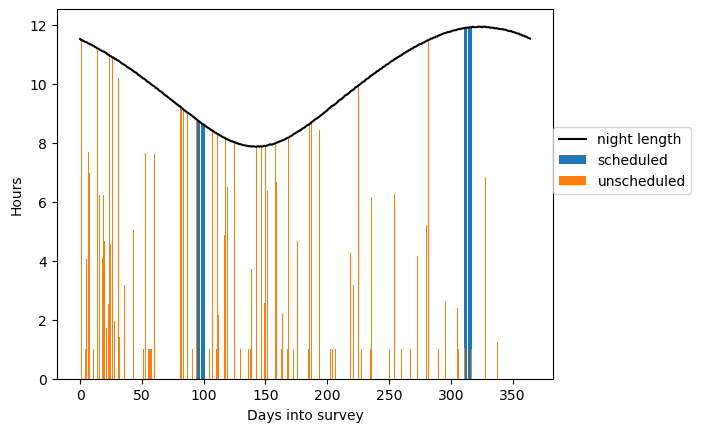

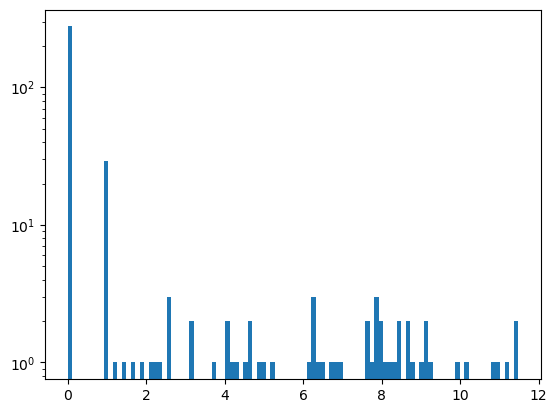

In [88]:
unsched_downtime = UnscheduledDowntimeDataYearOne(sunsets=sunset, sunrises=sunrise)

unscheduled_downtime = unsched_downtime()
unsched_down_mask = np.zeros(len(year1))
for start, end in zip(unscheduled_downtime['start'], unscheduled_downtime['end']):
    nn = np.where((year1 >= start.mjd) & (year1 <= end.mjd), 1, 0)
    unsched_down_mask += nn
unsched_down_mask = np.where(unsched_down_mask == 1, 0, 1)

scheduled_downtime = sched_downtime()
sched_down_mask = np.zeros(len(year1))
for start, end in zip(scheduled_downtime['start'], scheduled_downtime['end']):
    nn = np.where((year1 >= start.mjd) & (year1 <= end.mjd), 1, 0)
    sched_down_mask += nn
# Flip so that "1" is good and uptime
sched_down_mask = np.where(sched_down_mask == 1, 0, 1)

# Coincidence how close these are in the first year
print(len(np.where(unsched_down_mask == 0)[0]) * stepsize * 24, len(np.where(sched_down_mask == 0)[0]) * stepsize * 24)

night_len = []
sched_down_len = []
unsched_down_len = []
nnights = np.arange(0, nights.max())
for n in nnights:
    val = year1[np.where(nights == n)]
    night_len.append(len(val) * stepsize * 24)
    val = year1[np.where((nights == n) & (sched_down_mask == 0))]
    sched_down_len.append(len(val) * stepsize * 24)
    val = year1[np.where((nights == n) & (unsched_down_mask == 0))]
    unsched_down_len.append(len(val) * stepsize * 24)    
night_len = np.array(night_len)
sched_down_len = np.array(sched_down_len)
unsched_down_len = np.array(unsched_down_len)
plt.plot(nnights, night_len, color='k', label='night length')
plt.bar(nnights, sched_down_len, label='scheduled')
plt.bar(nnights, unsched_down_len, label='unscheduled')
plt.legend(loc=(1.0, 0.5))
plt.ylabel("Hours")
plt.xlabel("Days into survey")

plt.figure()
_ = plt.hist(unsched_down_len, bins=100, log=True)